In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
np.set_printoptions(precision=3, suppress=True)

In [2]:
### Environment 1 - 5/5% chance per timestep ###
class CTE:
    def __init__(self, lanes=5, window=30, time_step=10, distance=4000):
        self.lanes = lanes
        self.window = window
        self.time_step = time_step
        self.distance = distance
        self.reset()


    def reset(self):
        self.current_time = 0
        self.current_lane = 1   # enters the expressway from lane 1
        self.clearance_rates = np.random.uniform(
            15, 20, self.lanes
        )
        self.state = []
        adjustment = self.clearance_rates[self.current_lane-1]
        self.state = [
            (self.distance+2*adjustment, self.current_lane, *self.clearance_rates),
            (self.distance+adjustment, self.current_lane, *self.clearance_rates),
            (self.distance, self.current_lane, *self.clearance_rates)
        ]
        return self.get_state()


    def get_state(self):
        return [
            tuple(round(value, 2) if isinstance(value, float) else value for value in tup) \
            for tup in self.state
        ]


    def _update_traffic(self):
        changes = np.zeros(self.lanes)

        # simulate significant events
        rng = np.random.rand()
        event_lane = np.random.randint(0, self.lanes)
        if rng < 0.05:
            changes[event_lane] -= np.random.uniform(0.20,0.50) * deepcopy(self.clearance_rates[event_lane])
        elif rng < 0.10:
            changes[event_lane] += np.random.uniform(0.20,0.40) * deepcopy(self.clearance_rates[event_lane])

        for j in range(self.lanes):
            left_neighbor = self.clearance_rates[j-1] if j > 0 \
                else None
            right_neighbor = self.clearance_rates[j+1] if j < self.lanes - 1 \
                else None
            left_diff = 0 if left_neighbor is None \
                else np.sign(left_neighbor - self.clearance_rates[j]) * 0.2
            right_diff = 0 if right_neighbor is None \
                else np.sign(right_neighbor - self.clearance_rates[j]) * 0.2
            changes[j] += np.random.normal(0, 0.1) + left_diff + right_diff

        self.clearance_rates += changes    # performed outside loop so that the change is not sequential across lanes


    def _update_pos(self):
        new_distance = self.state[-1][0] - self.clearance_rates[self.current_lane-1]
        # lane 1 is at index 0, lane 5 at index 4
        new_observation = (new_distance, self.current_lane, *self.clearance_rates)
        self.current_time += self.time_step
        self.state.pop(0)  # remove observation outside window
        self.state.append(new_observation)


    def transition(self, action=0):
        """
        Args:
            action (int): -1 to switch left, 0 to stay (default), 1 to switch right
                          if action is -1 or 1, only 50% chance of success
        """
        reward = self.clearance_rates[self.current_lane-1] - 10

        if action != 0:
            reward -= 5   # penalty for attempting to change, regardless of success

            if np.random.rand() < 0.5:
                if action == -1 and self.current_lane > 1:
                    self.current_lane -= 1
                elif action == 1 and self.current_lane < self.lanes:
                    self.current_lane += 1

        self._update_traffic()
        self._update_pos()
        return self.get_state(), round(reward, 3)


### Environment 2 - 5/5% chance per lane per timestep ###
class PIE(CTE):
    def __init__(self, lanes=5, window=30, time_step=10, distance=4000):
        super().__init__(lanes, window, time_step, distance)

    def reset(self):
        super().reset()

    def _update_traffic(self):
        changes = np.zeros(self.lanes)

        # simulate significant events
        for lane in range(0, self.lanes):
            rng = np.random.rand()
            if rng < 0.05:
                changes[lane] -= np.random.uniform(0.20,0.50) * deepcopy(self.clearance_rates[lane])
            elif rng < 0.10:
                changes[lane] += np.random.uniform(0.20,0.40) * deepcopy(self.clearance_rates[lane])

        for j in range(self.lanes):
            left_neighbor = self.clearance_rates[j-1] if j > 0 \
                else None
            right_neighbor = self.clearance_rates[j+1] if j < self.lanes - 1 \
                else None
            left_diff = 0 if left_neighbor is None \
                else np.sign(left_neighbor - self.clearance_rates[j]) * 0.2
            right_diff = 0 if right_neighbor is None \
                else np.sign(right_neighbor - self.clearance_rates[j]) * 0.2
            changes[j] += np.random.normal(0, 0.1) + left_diff + right_diff

        self.clearance_rates += changes    # performed outside loop so that the change is not sequential across lanes



class MyopicAgent:
    def __init__(self):
        pass

    def act(self, state):
        latest = state[-1]
        current_dist = latest[0]
        current_lane = latest[1]
        clearance_rates = latest[2:]
        best_lane = np.argmax(clearance_rates) + 1

        if best_lane < current_lane:
            return -1
        elif best_lane > current_lane:
            return 1
        else:
            return 0


class RandomAgent:
    def __init__(self):
        pass

    def act(self, state):
        return np.random.randint(3)-1   # -1/0/1

In [3]:
def generate_history_CTE(n_steps=1000):
    agent = MyopicAgent()
    env = CTE(distance=4000)
    state = env.get_state()

    common_history = [state]
    for step in range(n_steps):   # use more than necessary to be safe
        action = agent.act(state)
        state, reward = env.transition(action)
        common_history.append(state)

    return common_history


def generate_history_PIE(n_steps=2000):
    agent = MyopicAgent()
    env = PIE(distance=4000)
    state = env.get_state()

    common_history = [state]
    for step in range(n_steps):   # use more than necessary to be safe
        action = agent.act(state)
        state, reward = env.transition(action)
        common_history.append(state)

    return common_history

In [4]:
def merge(current_lane, previous_state, latest_state, action):
    """
    Args:
        current_lane (int)
        previous_state: [(dt-3, ...), (dt-2, ...), (dt-1, ...)]
        latest_state: tuple of 7 numbers where last 5 shows clearance rate (dt, lt, vt1, vt2, vt3, vt4, vt5)
        action (int)
    """
    lane = current_lane
    travelled = latest_state[lane+1]   # lane 1 corresponds to index 2
    reward = travelled - 10

    if action != 0:
        reward -= 5   # penalty for attempting to change, regardless of success
        if np.random.rand() < 0.5:
            if action == -1 and lane > 1:
                lane -= 1
            elif action == 1 and lane < 5:
                lane += 1

    pos = round(previous_state[-1][0] - travelled, 3)
    vt1, vt2, vt3, vt4, vt5 = latest_state[2:]
    adjusted_state = previous_state[1:] + [(pos, lane, vt1, vt2, vt3, vt4, vt5)]  # append list-of-2-tuples to list-of-1-tuple

    return adjusted_state, lane, reward

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:13<00:00,  6.79it/s]


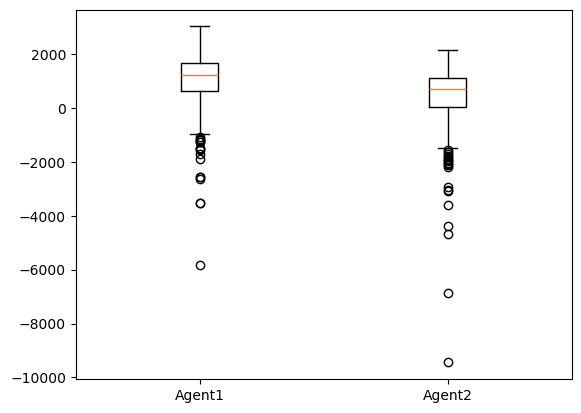

[(1038.552, 948.96878099124, 1222.0), (480.402, 1068.2707299163446, 725.5)]


In [5]:
random.seed(609)
np.random.seed(609)
torch.manual_seed(609)

agents = {
    'Agent1': MyopicAgent(),
    'Agent2': RandomAgent(),
}

results_CTE = {agent_name: [] for agent_name in agents.keys()}
results_PIE = {agent_name: [] for agent_name in agents.keys()}

### Environment 1 ###
for simulation in tqdm(range(500)):
    ## fix a random trajectory and starting lane to be applied to all agents
    common_history = generate_history_CTE(n_steps=1000)
    initial_lane = 1+np.random.randint(4)
    initial_state = common_history[0]

    for agent_name, agent in agents.items():
        #print("\nPerforming evaluation for %s" % agent_name)
        G = 0
        current_lane = deepcopy(initial_lane)
        previous_state = deepcopy(initial_state)
        action = agent.act(initial_state)

        # simulate one episode and compute reward
        for i, state in enumerate(common_history[1:]):
            adjusted_state, lane, reward = \
                merge(current_lane, previous_state, state[-1], action)

            G += reward
            previous_state = deepcopy(adjusted_state)
            current_lane = deepcopy(lane)
            action = agent.act(adjusted_state)   # applied to the next step

            if previous_state[-1][0] < 0:   # reached finish point
                break

        results_CTE[agent_name].append(int(G))


plt.boxplot(results_CTE.values())
plt.xticks(range(1, len(results_CTE)+1), results_CTE.keys())
plt.show()

print([(np.mean(x), np.std(x), np.median(x)) for x in results_CTE.values()])

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:23<00:00,  5.96it/s]


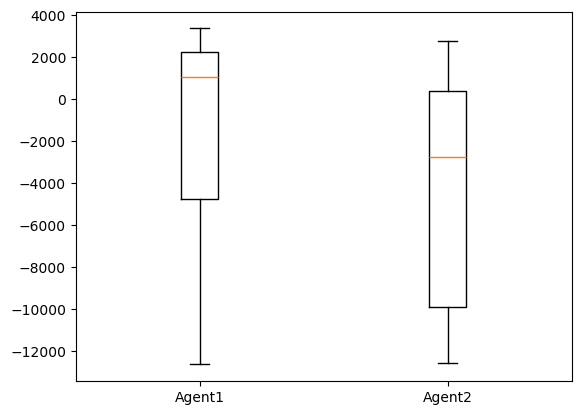

[(-1550.56, 5031.896809991238, 1044.5), (-4369.696, 5089.524862655059, -2768.5)]


In [6]:
random.seed(609)
np.random.seed(609)
torch.manual_seed(609)

### Environment 2 ###
for simulation in tqdm(range(500)):
    ## fix a random trajectory and starting lane to be applied to all agents
    common_history = generate_history_PIE(n_steps=1000)
    initial_lane = 1+np.random.randint(4)
    initial_state = common_history[0]

    for agent_name, agent in agents.items():
        #print("\nPerforming evaluation for %s" % agent_name)
        G = 0
        current_lane = deepcopy(initial_lane)
        previous_state = deepcopy(initial_state)
        action = agent.act(initial_state)

        # simulate one episode and compute reward
        for i, state in enumerate(common_history[1:]):
            adjusted_state, lane, reward = \
                merge(current_lane, previous_state, state[-1], action)

            G += reward
            previous_state = deepcopy(adjusted_state)
            current_lane = deepcopy(lane)
            action = agent.act(adjusted_state)   # applied to the next step

            if previous_state[-1][0] < 0:   # reached finish point
                break

        results_PIE[agent_name].append(int(G))


plt.boxplot(results_PIE.values())
plt.xticks(range(1, len(results_PIE)+1), results_PIE.keys())
plt.show()

print([(np.mean(x), np.std(x), np.median(x)) for x in results_PIE.values()])


### Group 1

### Group 2

### Group 3

### Group 4

### Group 7

### Group 8

### Group 9

### Group 0

In [7]:
from stable_baselines3 import PPO
from stable_baselines3 import DQN

In [8]:
class PPOAgent:
    def __init__(self, model_path):
        self.model = PPO.load(model_path, device='cpu')

    def act(self, state):
        """
        Decide an action based on the PPO model.
        Args:
            state (list): Current state as expected by the PPO model.
        Returns:
            int: Action to take (-1, 0, or 1).
        """
        # Convert the state to the format expected by the PPO model
        state_array = np.array(state).flatten()
        action, _ = self.model.predict(state_array, deterministic=True)
        # Map action to -1, 0, or 1 as per evaluation requirements
        return action - 1

In [9]:
class DQNAgent:
    def __init__(self, model_path):
        self.model = DQN.load(
            model_path,
            custom_objects={"clip_range": None, "lr_schedule": None}
        )

    def act(self, state):
        processed_state = self.preprocess_state(state[-1])
        action, _ = self.model.predict(processed_state, deterministic=True)
        return action - 1  

    def preprocess_state(self, state):
        state_array = np.array(state).flatten()
        expected_shape = self.model.observation_space.shape[0]
        if len(state_array) < expected_shape:
            state_array = np.pad(state_array, (0, expected_shape - len(state_array)), mode="constant")
        elif len(state_array) > expected_shape:
            state_array = state_array[:expected_shape]
        return state_array


D:\App\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
D:\App\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [06:26<00:00,  1.29it/s]


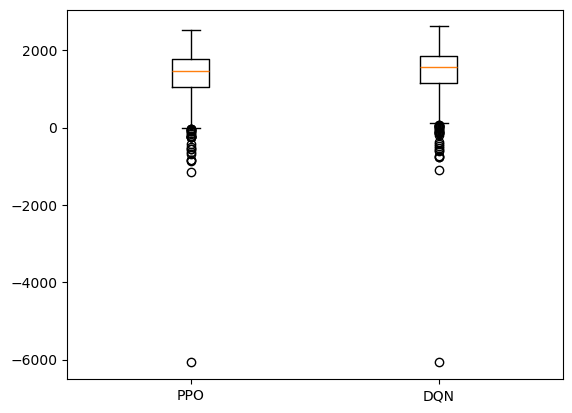

[(1325.764, 716.2744113145463, 1477.0), (1400.572, 718.1025531329074, 1560.5)]


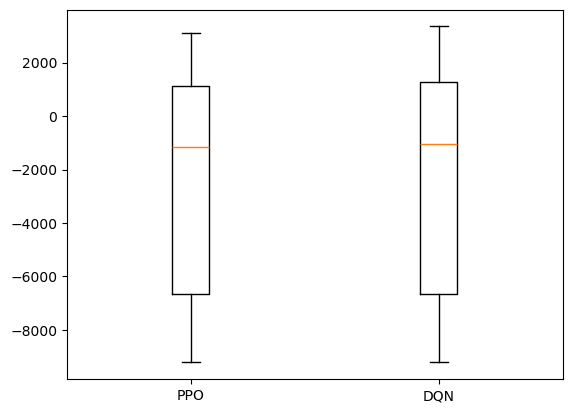

[(-2416.75, 3856.7064813776014, -1148.0), (-2328.246, 3913.901492051633, -1040.0)]


In [10]:

##### Load your libraries and define your classes & functions here #####
##### Replace here #####

agents = {
    'PPO': PPOAgent("./models/ppo_best_model_task1"),
    'DQN': DQNAgent("./models/dqn_best_model_task1"),  
}

results = {agent_name: [] for agent_name in agents.keys()}

random.seed(609)
np.random.seed(609)
torch.manual_seed(609)


results_CTE = {agent_name: [] for agent_name in agents.keys()}
results_PIE = {agent_name: [] for agent_name in agents.keys()}

### Environment 1 ###
for simulation in tqdm(range(500)):
    ## fix a random trajectory and starting lane to be applied to all agents
    common_history = generate_history_CTE(n_steps=1000)
    initial_lane = 1+np.random.randint(4)
    initial_state = common_history[0]

    for agent_name, agent in agents.items():
        G = 0
        current_lane = deepcopy(initial_lane)
        previous_state = deepcopy(initial_state)
        action = agent.act(initial_state)     ##### Your agent acts here #####

        for i, state in enumerate(common_history[1:]):
            adjusted_state, lane, reward = \
                merge(current_lane, previous_state, state[-1], action)

            G += reward
            previous_state = deepcopy(adjusted_state)
            current_lane = deepcopy(lane)
            action = agent.act(adjusted_state)   # applied to the next step

            if previous_state[-1][0] < 0:   # reached finish point
                break

        results_CTE[agent_name].append(int(G))


### Environment 2 ###
for simulation in tqdm(range(500)):
    ## fix a random trajectory and starting lane to be applied to all agents
    common_history = generate_history_PIE(n_steps=1000)
    initial_lane = 1+np.random.randint(4)
    initial_state = common_history[0]

    for agent_name, agent in agents.items():
        G = 0
        current_lane = deepcopy(initial_lane)
        previous_state = deepcopy(initial_state)
        action = agent.act(initial_state)     ##### Your agent acts here #####

        for i, state in enumerate(common_history[1:]):
            adjusted_state, lane, reward = \
                merge(current_lane, previous_state, state[-1], action)

            G += reward
            previous_state = deepcopy(adjusted_state)
            current_lane = deepcopy(lane)
            action = agent.act(adjusted_state)   # applied to the next step

            if previous_state[-1][0] < 0:   # reached finish point
                break

        results_PIE[agent_name].append(int(G))


plt.boxplot(results_CTE.values())
plt.xticks(range(1, len(results_CTE)+1), results_CTE.keys())
plt.show()

print([(np.mean(x), np.std(x), np.median(x)) for x in results_CTE.values()])


plt.boxplot(results_PIE.values())
plt.xticks(range(1, len(results_PIE)+1), results_PIE.keys())
plt.show()

print([(np.mean(x), np.std(x), np.median(x)) for x in results_PIE.values()])